In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [42]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [3]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [4]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [5]:
airi_dat

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) datetime64[ns] 1871-02-01 1871-03-01 ... 2017-01-01
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0

In [6]:
precip = airi_dat['precip']

In [8]:
#Load MSE data
dataset_url = "MSE_20thcentury.nc"
mse_dat1 = xr.open_dataset('/global/scratch/medhap02/ISMData/MSE_20thcentury.nc')
mse_dat = mse_dat1.rename({'LON':'lon', 'LAT':'lat','TIME':'time'})
mse = mse_dat['MSE']
print(mse_dat)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 181, lon: 360, time: 2160)
Coordinates:
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time       (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (time, bnds) datetime64[ns] ...
    MSE        (time, lat, lon) float64 ...
    DMSEDT     (time, lat, lon) float64 ...
Attributes:
    history:      PyFerret V7.43 (optimized) 14-May-20
    Conventions:  CF-1.6


In [9]:
mse[1950,:,:]

<xarray.DataArray 'MSE' (lat: 181, lon: 360)>
array([[226840.197219, 226840.197219, 226840.197219, ..., 226840.197219,
        226840.197219, 226840.197219],
       [226843.584283, 226823.131608, 226809.02599 , ..., 226897.710251,
        226880.505183, 226861.215806],
       [226515.43398 , 226459.668853, 226407.824075, ..., 226725.489409,
        226656.641126, 226584.999081],
       ...,
       [284155.095137, 284155.923731, 284155.640129, ..., 284148.737619,
        284151.610734, 284153.2147  ],
       [284101.037336, 284101.122701, 284101.141537, ..., 284099.908306,
        284100.971691, 284101.521576],
       [284026.176127, 284026.176127, 284026.176127, ..., 284026.176127,
        284026.176127, 284026.176127]])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    time     datetime64[ns] 1998-07-01
Attributes:
    long_name:  Moist Static Energy
    uni

In [10]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1871-01-30','2017-01-01'))
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
mse_anomfull

<xarray.DataArray 'MSE' (time: 1739, lat: 181, lon: 360)>
array([[[ -437.976186,  -437.976186, ...,  -437.976186,  -437.976186],
        [ -357.903304,  -357.881208, ...,  -348.426553,  -351.846723],
        ...,
        [-4136.464814, -4142.140899, ..., -4125.058225, -4129.258011],
        [-3946.385781, -3946.385781, ..., -3946.385781, -3946.385781]],

       [[ -685.706864,  -685.706864, ...,  -685.706864,  -685.706864],
        [ -523.262003,  -522.176401, ...,  -528.206152,  -525.088336],
        ...,
        [-2774.219152, -2771.776149, ..., -2769.221152, -2770.293549],
        [-2662.830975, -2662.830975, ..., -2662.830975, -2662.830975]],

       ...,

       [[ 2257.7285  ,  2257.7285  , ...,  2257.7285  ,  2257.7285  ],
        [ 2691.46434 ,  2695.995047, ...,  2682.928563,  2688.836707],
        ...,
        [ 3071.988646,  3092.121979, ...,  3027.33813 ,  3049.99822 ],
        [ 3156.791382,  3156.791382, ...,  3156.791382,  3156.791382]],

       [[  864.856915,   864.856

In [11]:
mse_subset1 = mse_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
mse_subset2 = mse_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
mse_subset3 = mse_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
mse_subset4 = mse_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
mse_subset5 = mse_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
mse_subset6 = mse_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
mse_subset7 = mse_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
mse_subset8 = mse_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
mse_subset9 = mse_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
mse_subset10 = mse_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
mse_subset11 = mse_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
mse_subset12 = mse_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
mse_subset13 = mse_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
mse_subset14 = mse_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
mse_subset15 = mse_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
mse_subset16 = mse_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
mse_subset17 = mse_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
mse_subset18 = mse_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
mse_subset19 = mse_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
mse_subset20 = mse_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
mse_subset21 = mse_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
mse_subset22 = mse_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
mse_subset23 = mse_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

mse_anomtemp = xr.merge([mse_subset1, mse_subset2, mse_subset3, mse_subset4, mse_subset5, 
                   mse_subset6, mse_subset7, mse_subset8, mse_subset9, mse_subset10, 
                   mse_subset11, mse_subset12, mse_subset13, mse_subset14, mse_subset15, 
                   mse_subset16, mse_subset17, mse_subset18, mse_subset19, mse_subset20, 
                   mse_subset21, mse_subset22, mse_subset23])
#mse_anom = xr.Dataset.to_array(mse_anomtemp).drop('variable')
print(mse_anomtemp)
mse_anom = mse_anomtemp['MSE']
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 1056)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2015-12-01
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    MSE      (time, lat, lon) float64 -436.0 -436.0 ... 1.634e+03 1.634e+03


In [12]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

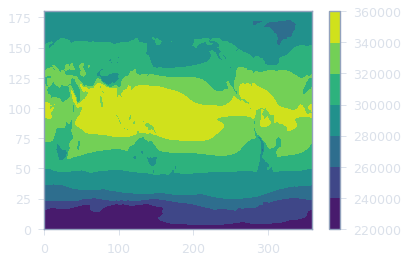

In [13]:
#Test plot of mse_clim
plt.contourf(mse_clim.sel(month=6))
plt.colorbar()

In [14]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim

In [15]:
precip_subset1 = precip_anomfull.sel(time=slice('1900-01-01','1901-12-31'))
precip_subset2 = precip_anomfull.sel(time=slice('1903-01-01','1906-12-31'))
precip_subset3 = precip_anomfull.sel(time=slice('1908-01-01','1911-12-31'))
precip_subset4 = precip_anomfull.sel(time=slice('1913-01-01','1913-12-31'))
precip_subset5 = precip_anomfull.sel(time=slice('1915-01-01','1918-12-31'))
precip_subset6 = precip_anomfull.sel(time=slice('1920-01-01','1921-12-31'))
precip_subset7 = precip_anomfull.sel(time=slice('1923-01-01','1927-12-31'))
precip_subset8 = precip_anomfull.sel(time=slice('1929-01-01','1931-12-31'))
precip_subset9 = precip_anomfull.sel(time=slice('1934-01-01','1939-12-31'))
precip_subset10 = precip_anomfull.sel(time=slice('1941-01-01','1948-12-31'))
precip_subset11 = precip_anomfull.sel(time=slice('1951-01-01','1955-12-31'))
precip_subset12 = precip_anomfull.sel(time=slice('1957-01-01','1958-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1960-01-01','1962-12-31'))
precip_subset13 = precip_anomfull.sel(time=slice('1964-01-01','1965-12-31'))
precip_subset14 = precip_anomfull.sel(time=slice('1967-01-01','1971-12-31'))
precip_subset15 = precip_anomfull.sel(time=slice('1973-01-01','1976-12-31'))
precip_subset16 = precip_anomfull.sel(time=slice('1978-01-01','1979-12-31'))
precip_subset17 = precip_anomfull.sel(time=slice('1981-01-01','1982-12-31'))
precip_subset18 = precip_anomfull.sel(time=slice('1984-01-01','1991-12-31'))
precip_subset19 = precip_anomfull.sel(time=slice('1993-01-01','1998-12-31'))
precip_subset20 = precip_anomfull.sel(time=slice('2000-01-01','2002-12-31'))
precip_subset21 = precip_anomfull.sel(time=slice('2004-01-01','2006-12-31'))
precip_subset22 = precip_anomfull.sel(time=slice('2008-01-01','2010-12-31'))
precip_subset23 = precip_anomfull.sel(time=slice('2012-01-01','2015-12-31'))

precip_anom = xr.merge([precip_subset1, precip_subset2, precip_subset3, precip_subset4, precip_subset5, 
                   precip_subset6, precip_subset7, precip_subset8, precip_subset9, precip_subset10, 
                   precip_subset11, precip_subset12, precip_subset13, precip_subset14, precip_subset15, 
                   precip_subset16, precip_subset17, precip_subset18, precip_subset19, precip_subset20, 
                   precip_subset21, precip_subset22, precip_subset23])
precip_anomtemp = xr.Dataset.to_array(precip_anom)
precip_anom = precip_anom['precip']
print(precip_anom)
#1902, 1907, 1912, 1914, 1919, 1922, 1928, 1932, 1933, 1940
#1949, 1950, 1956, 1959, 1963, 1966, 1972, 1977, 1980, 1983
#1992, 1999, 2003, 2007, 2011

<xarray.DataArray 'precip' (time: 1056)>
array([ -9.166439,   4.535616,  -5.745206, ..., -44.439735, -40.930824,
        13.444523], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2015-12-01
    month    (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 8.0 9.0 10.0 11.0 12.0


/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


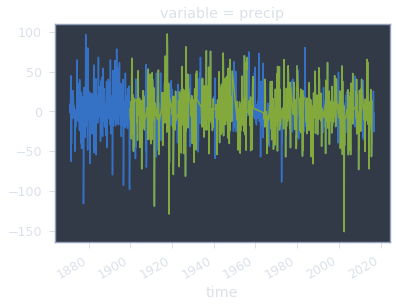

In [16]:
precip_anomfull.plot()
precip_anomtemp.plot()

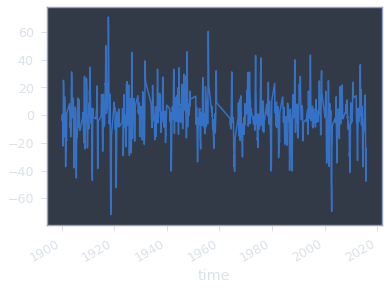

In [17]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [18]:
#Seasonal means of mseA
msea_seasonal = mse_anom.rolling(time=3,center=True).mean()
msea_seasonal

<xarray.DataArray (time: 1056, lat: 181, lon: 360)>
array([[[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[ -29.739481,  -29.739481, ...,  -29.739481,  -29.739481],
        [ -57.347446,  -56.362034, ...,  -57.461762,  -57.631168],
        ...,
        [ 196.47479 ,  192.495343, ...,  203.931508,  199.956729],
        [ 269.885766,  269.885766, ...,  269.885766,  269.885766]],

       ...,

       [[1959.02195 , 1959.02195 , ..., 1959.02195 , 1959.02195 ],
        [2319.40898 , 2322.228529, ..., 2311.888569, 2315.323729],
        ...,
        [3280.796831, 3284.9386  , ..., 3271.36981 , 3275.704135],
        [3341.58319 , 3341.58319 , ..., 3341.58319 , 3341.58319 ]],

       [[        nan,         nan, ...,         nan,         nan],
        [        na

#Test plot of seasonal SST anomalies in DJF 1997-8
plt.contourf(ssta_seasonal.sel(time='1998-01-01'))
plt.colorbar()

In [19]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [20]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = msea_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
mse_r = correlation(x, y, dims='time')
#y = msea_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'

Text(0.5, 1.0, 'Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)')

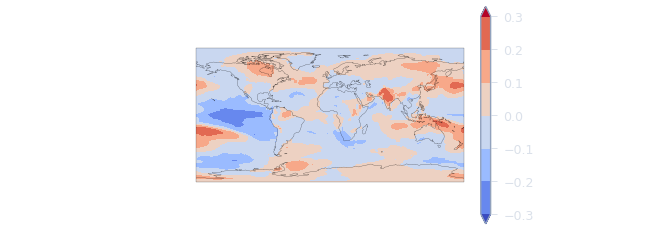

In [21]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)', color = 'white')

In [22]:
#Try the same with only JJA:
julys=np.arange(6,1056,12) #1752 instead of 1068
msea_jja = msea_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
mse_jja_r = correlation(msea_jja,precipa_jja,dims='time')

Text(0.5, 1.0, 'Contemporaneous Correlation Between MSE and AIRI Anomalies (JJA Mean)')

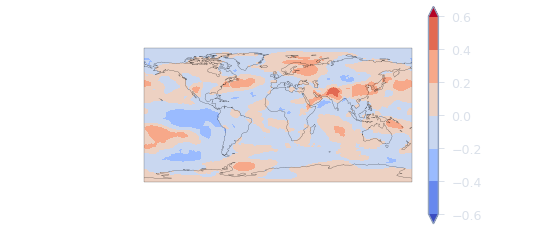

In [23]:
#Plot JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_jja_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_jja_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (JJA Mean)', color = 'white')

In [24]:
#Try this with a lag of 3 months
msea_seasonal_3shift = msea_seasonal.shift(time=-3)
msea_mam = msea_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted MSEA (by 3 months)')

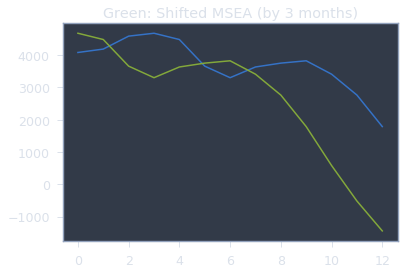

In [25]:
plt.plot(msea_seasonal.sel(lon=270,lat=0,time=slice('1987-01-01','1988-01-01')))
plt.plot(msea_seasonal_3shift.sel(lon=270,lat=0,time=slice('1987-01-01','1988-01-01')))
plt.title('Green: Shifted MSEA (by 3 months)')

In [26]:
#Run correlation
mse_mam_r = correlation(msea_mam,precipa_jja,dims='time')

Text(0.5, 1.0, 'Correlation Between MAM MSE and JJA AIRI Anomalies')

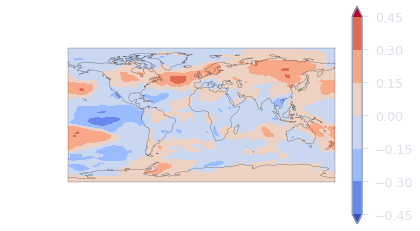

In [27]:
#Plot MAM/JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_mam_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_mam_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Correlation Between MAM MSE and JJA AIRI Anomalies', color = 'white')

In [28]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
msea_2shift_dt = mse_anom-mse_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1056,12)
precipa_jjas = precipa_4seasonal[septembers]
msea_2shift_dt_sep = msea_2shift_dt.shift(time=4)[septembers,:,:]

In [29]:
mse_may_mar_r = correlation(msea_2shift_dt_sep,precipa_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

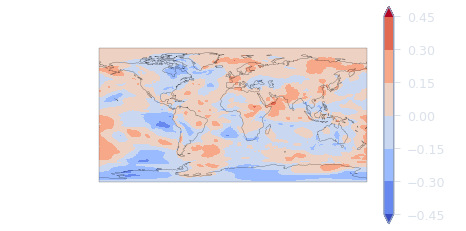

In [30]:
#Plot correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_may_mar_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_may_mar_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')

# correlations part 2

In [31]:
#Try the same with only JJA:
march = np.arange(2,1056,12)
april = np.arange(3,1056,12)
may = np.arange(4,1056,12)

junes = np.arange(5,1056,12)
julys = np.arange(6,1056,12) #1752 instead of 1068
augusts = np.arange(7,1056, 12)
septembers = np.arange(8,1056,12)

msea_march = mse_anom[march,:,:]
msea_april = mse_anom[april,:,:]
msea_may = mse_anom[may,:,:]

msea_march.time.data = msea_may.time.data
msea_april.time.data = msea_may.time.data

precipa_june = precip_anom[junes]
precipa_july = precip_anom[julys]
precipa_august = precip_anom[augusts]
precipa_september = precip_anom[septembers]

precipa_july.time.data = precipa_june.time.data
precipa_august.time.data = precipa_june.time.data
precipa_september.time.data = precipa_june.time.data

precipa_jjas = precipa_june + precipa_july + precipa_august + precipa_september

In [32]:
msea_mam = msea_march + msea_april + msea_may
msea_may_mar = msea_may - msea_march
msea_ma = msea_march + msea_april
msea_am = msea_april + msea_may
msea_may_apr = msea_may - msea_april
precipa_jjas.time.data = msea_mam.time.data

Text(0.5, 1.0, 'Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies')

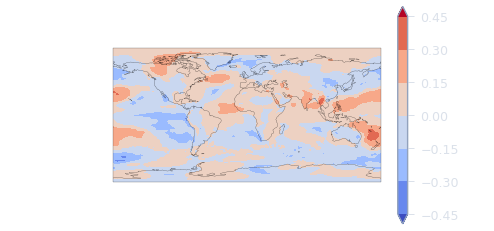

In [33]:
mse_mam_r = correlation(msea_mam,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_mam_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
plt.title('Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

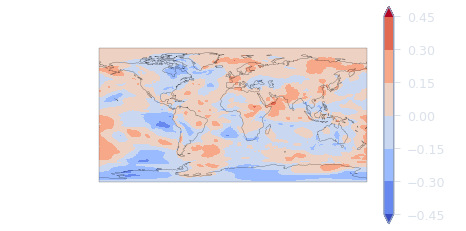

In [34]:
mse_may_mar_r = correlation(msea_may_mar,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between MarchApril MSEA and JJAS AIRI Anomalies')

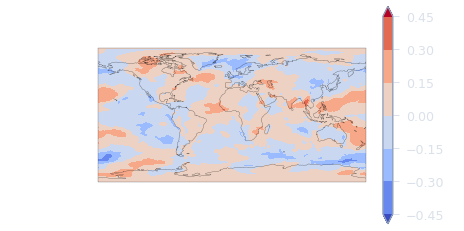

In [35]:
mse_ma_r = correlation(msea_ma,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_ma_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
plt.title('Correlation Between MarchApril MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between AprilMay MSEA and JJAS AIRI Anomalies')

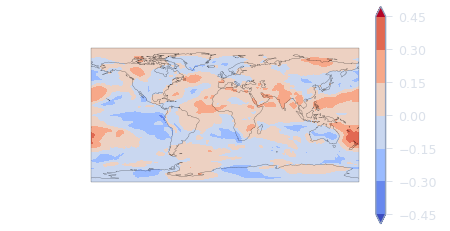

In [36]:
mse_am_r = correlation(msea_am,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_am_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
plt.title('Correlation Between AprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-April MSEA and JJAS AIRI Anomalies')

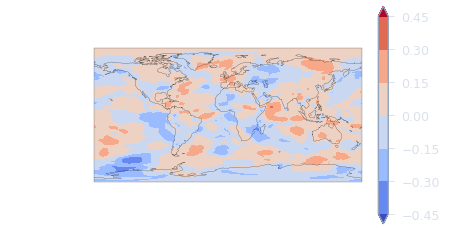

In [37]:
mse_may_apr_r = correlation(msea_may_apr,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_apr_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
plt.title('Correlation Between May-April MSEA and JJAS AIRI Anomalies', color = 'white')

# new boxes

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies, predictor 5')

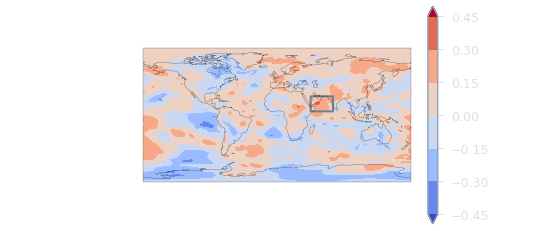

In [38]:
mse_may_mar_r = correlation(msea_may_mar,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[45,5], width=30, height=20, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies, predictor 5', color = 'white')

Text(0.5, 1.0, 'Correlation Between AprilMay MSEA and JJAS AIRI Anomalies, predictor 6')

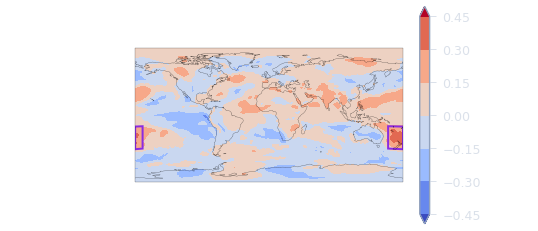

In [39]:
mse_am_r = correlation(msea_am,precipa_jjas,dims='time')
ax = plt.axes(projection=ccrs.PlateCarree())
mse_am_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[160,-45], width=30, height=30, facecolor=None, edgecolor='blueviolet', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
plt.title('Correlation Between AprilMay MSEA and JJAS AIRI Anomalies, predictor 6', color = 'white')

# boxes being tested

Text(0.5, 1.0, 'Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies')

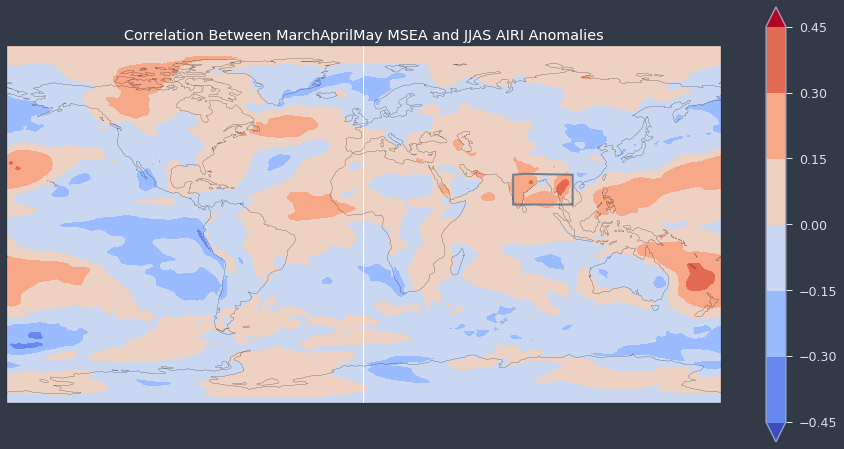

In [43]:
ax = plt.axes(projection=ccrs.PlateCarree())
mse_mam_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[75,10], width=30, height=15, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(10-25n, 75-105e)
plt.title('Correlation Between MarchAprilMay MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

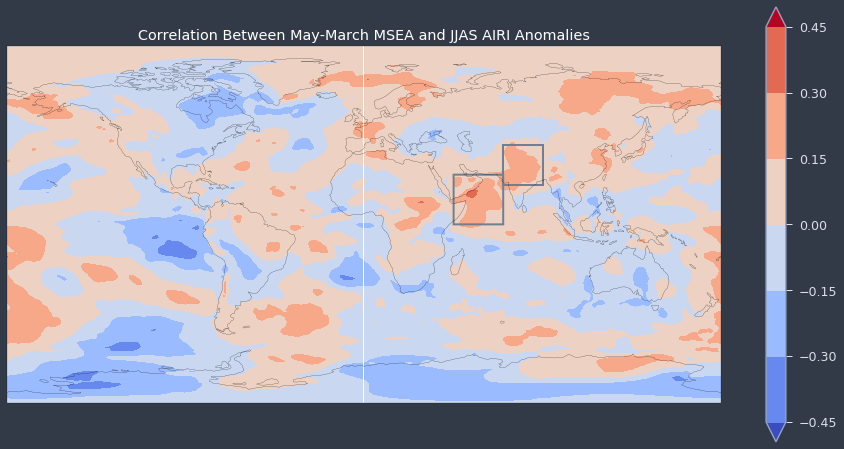

In [44]:
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[45,0], width=25, height=25, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(0-25n, 45-70e)
ax.add_patch(mpatches.Rectangle(xy=[70,20], width=20, height=20, facecolor=None, edgecolor='slategray', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(20-40n, 70-90e)
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies, predictor 5')

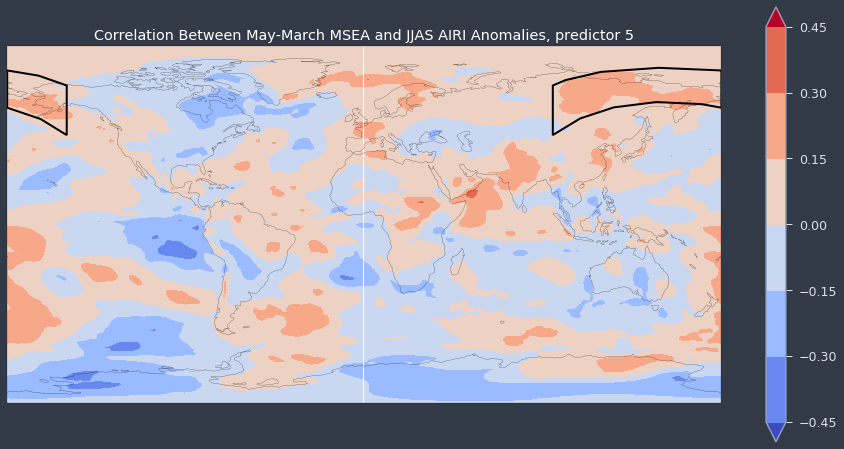

In [60]:
ax = plt.axes(projection=ccrs.PlateCarree())
mse_may_mar_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=115, height=25, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#(45-70n, 95e-150w)
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies, predictor 5', color = 'white')

In [ ]:
# Copyright (c) 2020 Medha Palavalli.